In [124]:
import os
import pandas as pd
import numpy as np

from keras.initializers import he_uniform
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.layers import Lambda, Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

seed=11
np.random.seed(seed)

## 1. Getting Data

In [125]:
dataset_path = '../datasets/'
augmentations_path = os.path.join(dataset_path, 'augmentations')

train_path = os.path.join(dataset_path, 'train.csv')
test_path = os.path.join(dataset_path, 'test.csv')

In [126]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print(train_data.shape, test_data.shape)

(42000, 785) (28000, 784)


In [127]:
trainX = train_data.iloc[:,1:].values.astype(np.float32)
trainy = train_data.iloc[:,0].values.astype(np.float32)

## 2. Data Transformation

In [128]:
image_size = 28
color_channels = 1

train_m = trainX.shape[0]

trainX = trainX.reshape(train_m, image_size,image_size,color_channels)
trainY = np_utils.to_categorical(trainy)



## 3. Augmentation

### 3.1 All Class Augs

In [129]:
num_batches = 1024*64
batch_size = 2
dataX = trainX
dataY = trainy
num_classes = 1#trainY.shape[1]

shifted_X = np.ndarray((num_batches, batch_size, image_size*image_size))
shifted_Y = np.ndarray((num_batches, batch_size, num_classes))

print(num_batches*batch_size,'new images will be generated')

131072 new images will be generated


In [178]:
data_gen_args = dict(rotation_range=8,
                     width_shift_range=0.15,
                     height_shift_range=0.15,
                     fill_mode='nearest',
                    )

In [179]:
shifted_datagen = ImageDataGenerator(**data_gen_args)

shifted_datagen.fit(dataX)

i=0
for batch in shifted_datagen.flow(dataX, dataY, batch_size=batch_size):
    if i==num_batches: break
    if i%10000==0: print('batch:',i)
    
    batchX, batchY = batch
    

    shifted_X[i,:,:] = batchX.reshape(batch_size, -1)
    shifted_Y[i,:,:] = batchY.reshape(batch_size, -1)
    i+=1

batch: 0
batch: 10000
batch: 20000
batch: 30000
batch: 40000
batch: 50000
batch: 60000


array([4.])

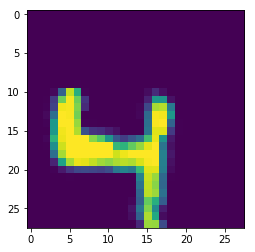

In [196]:
batch_i=np.random.randint(num_batches)
data_i=np.random.randint(batch_size)

plt.imshow(shifted_X[batch_i, data_i].reshape(28,28))
shifted_Y[batch_i, data_i]

#### Saving Augmentations

In [197]:
filename = 'class-every.csv'

filepath = os.path.join(augmentations_path,filename)

In [198]:
shifted_X = shifted_X.reshape((batch_size*num_batches, image_size*image_size))
shifted_Y = shifted_Y.reshape(-1,1)

shifted_augmentations = pd.DataFrame(np.c_[shifted_Y, shifted_X], columns=train_data.columns)

In [199]:
shifted_augmentations.label.value_counts()

1.0    14638
7.0    13768
3.0    13567
9.0    13066
2.0    13056
6.0    12901
0.0    12891
4.0    12674
8.0    12667
5.0    11844
Name: label, dtype: int64

In [200]:
shifted_X.shape

(131072, 784)

In [201]:
with open(filepath, 'w') as f:
    f.write(shifted_augmentations.to_csv(index=False))